In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import root_mean_squared_log_error
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../cleaned_dataset_without_na.csv', delimiter='|')
data.head()

,title,area,number_of_rooms,floor,type_of_market,parking,elevator,year_of_creation,internet,type_of_building,basement,price_for_m2_in_PLN,balcony,garden,terrace,street,district,city,latitude,longtitude
0,"Apartament inwestycyjny, ostatnie piętro, k/Sk...",24.89,1.0,4-6,secondary,0,1,2022.0,1.0,Mieszkanie,0.0,16749.98,0,0,0,śląska 12,przymorze,gdansk,54.406171,18.576846
1,Apartament inwestycyjny Śląska 12 z umową najmu!,25.72,1.0,0,secondary,0,1,2022.0,1.0,Mieszkanie,0.0,18500.00,0,0,0,śląska 12,przymorze,gdansk,54.406171,18.576846
2,"Nowe mieszkanie, wykończone - Mariana Kołodzieja",34.38,2.0,1-3,secondary,1,1,2022.0,1.0,Mieszkanie,0.0,15997.67,1,0,0,mariana kołodzieja,ujeścisko-łostowice,gdansk,54.334542,18.585750
3,"Wyjątkowe mieszkanie w centrum Gdyni, blisko l...",101.58,4.0,4-6,secondary,0,1,1997.0,1.0,Mieszkanie,0.0,11468.79,0,0,0,janusza korczaka,redłowo,gdynia,54.494118,18.543134
4,Mieszkanie w świetnej lokalizacji Gdynia Dąbrowa,68.00,3.0,1-3,secondary,0,0,2000.0,1.0,Mieszkanie,1.0,10279.41,1,0,0,oliwkowa,dąbrowa,gdynia,54.471180,18.470508


In [3]:
data = data.drop('title', axis=1)
threshold_low = 5000  # Set your threshold value here
threshold_high = 30000
data = data[data['price_for_m2_in_PLN'] >= threshold_low]
data = data[data['price_for_m2_in_PLN'] <= threshold_high]


In [4]:
data_numerical = data.drop(['city', 'district', 'type_of_market', 'type_of_building', 'floor', 'street'], axis=1)

In [5]:
A = data.drop(['price_for_m2_in_PLN', 'street'], axis=1)
b = data['price_for_m2_in_PLN']
X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=0.2, random_state=0)

In [6]:
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
preprocessor = ColumnTransformer([("cat", cat_pipeline, make_column_selector(dtype_include=object)),], remainder=num_pipeline)
preprocessor = preprocessor.fit(X_train, y_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [7]:
# Creating ANN model
from keras.src.models import Sequential
from keras.src.layers import Dense

In [8]:
model = Sequential()
model.add(Dense(1000, input_dim=X_train_preprocessed.shape[1], activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

In [9]:
from keras.src.callbacks import EarlyStopping
from keras.src.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.src import optimizers

optimizer = optimizers.Adam(learning_rate=0.01)

model.compile(loss='mean_squared_error', optimizer=optimizer)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)

In [10]:
X_train_preprocessed_np = X_train_preprocessed.toarray()

In [11]:
# Train the model
model.fit(X_train_preprocessed_np, y_train, epochs=600, batch_size=256, validation_split=0.2, callbacks=[mcp_save, reduce_lr, earlyStopping])

Epoch 1/600

28/28 [==============================] - 2s 40ms/step - loss: 177360672.0000 - val_loss: 57397280.0000 - lr: 0.0100
Epoch 2/600
28/28 [==============================] - 1s 29ms/step - loss: 34459212.0000 - val_loss: 26253370.0000 - lr: 0.0100
Epoch 3/600
28/28 [==============================] - 1s 28ms/step - loss: 38774704.0000 - val_loss: 13498779.0000 - lr: 0.0100
Epoch 4/600
28/28 [==============================] - 1s 26ms/step - loss: 11294130.0000 - val_loss: 10457127.0000 - lr: 0.0100
Epoch 5/600
28/28 [==============================] - 1s 29ms/step - loss: 9694466.0000 - val_loss: 10172198.0000 - lr: 0.0100
Epoch 6/600
28/28 [==============================] - 1s 27ms/step - loss: 9365295.0000 - val_loss: 10036089.0000 - lr: 0.0100
Epoch 7/600
28/28 [==============================] - 1s 26ms/step - loss: 8996858.0000 - val_loss: 9818449.0000 - lr: 0.0100
Epoch 8/600
28/28 [==============================] - 1s 31ms/step - loss: 8660938.0000 - val_loss: 9344979.0000 -

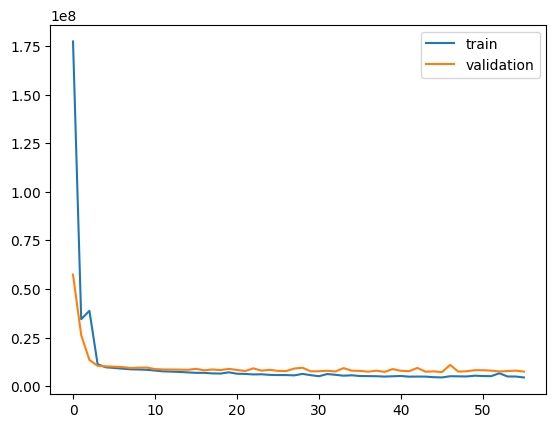

In [12]:
#Accuracy during training
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.legend()
plt.show()

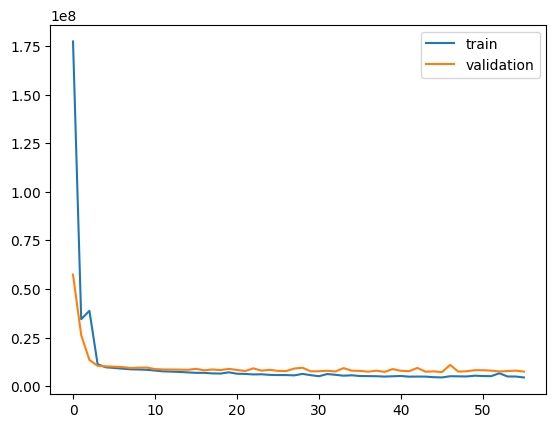

In [13]:
#Accuracy during training
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.legend()
plt.show()

70/70 [==============================] - 0s 4ms/step


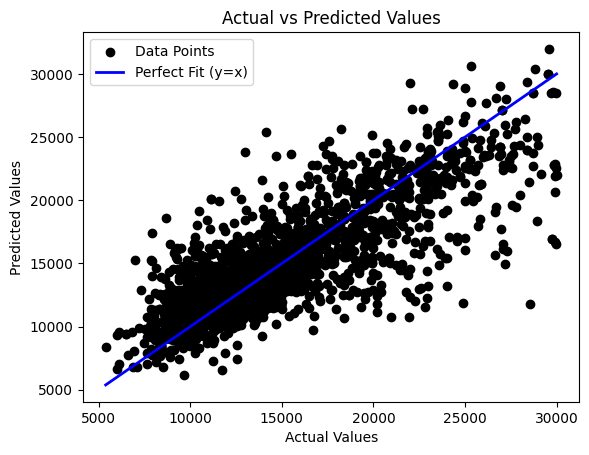

In [14]:
from keras.saving import load_model

# Predictions
model = load_model('best_model.keras')
y_pred_ANN = model.predict(X_test_preprocessed)

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_ANN, color="black", label="Data Points")
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color="blue", linewidth=2, label="Perfect Fit (y=x)")
# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [15]:
rmse_ANN = root_mean_squared_error(y_test, y_pred_ANN)
rmse_ANN

2817.328978838525

In [16]:
from sklearn.metrics import mean_absolute_error
mae_ANN = mean_absolute_error(y_test, y_pred_ANN)
mae_ANN

1943.3653132427992

In [17]:
r2_ann = r2_score(y_test, y_pred_ANN)
r2_ann

0.6721472836352012